In [10]:
from dotenv import load_dotenv
import os

# Load the .env file into environment variables
load_dotenv()

# Now you can access the keys as environment variables
groq_key = os.getenv("GROQ_API_KEY")
tavily_key = os.getenv("TAVILY_API_KEY")

print("GROQ_API_KEY:", groq_key)
print("TAVILY_API_KEY:", tavily_key)


GROQ_API_KEY: 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
TAVILY_API_KEY: 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


In [11]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings,
)
retriever = vectorstore.as_retriever()


In [12]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.",
)

tools = [retriever_tool]


In [13]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]


In [14]:
from typing import Annotated, Literal, Sequence, TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

from langgraph.prebuilt import tools_condition

### Assume this is your LLaMA 3.2 model already set:
# from langchain_community.llms import Ollama
# llm = Ollama(model="llama3")  
# (Or wherever you have defined your `llm`.)

# tools: you already have retriever_tool earlier
# tools = [retriever_tool]


### Edges

def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.
    """
    print("---CHECK RELEVANCE---")

    class grade(BaseModel):
        """Binary score for relevance check."""
        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # Use your LLaMA model (NOT ChatOpenAI)
    model_with_tool = llm.with_structured_output(grade)

    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. 
Here is the retrieved document: 
\n\n {context} \n\n
Here is the user question: {question} 
\n
If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant.
Give a binary score 'yes' or 'no'.""",
        input_variables=["context", "question"],
    )

    chain = prompt | model_with_tool

    messages = state["messages"]
    last_message = messages[-1]
    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "rewrite"


### Nodes

def agent(state):
    """
    Calls the agent model to generate a response based on the current state.
    """
    print("---CALL AGENT---")
    messages = state["messages"]

    # Use your LLaMA model with tools
    model = llm.bind_tools(tools)

    response = model.invoke(messages)
    return {"messages": [response]}


def rewrite(state):
    """
    Rewrites or improves the user question if the retrieved documents were irrelevant.
    """
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    new_prompt = [
        HumanMessage(
            content=f""" 
Look at the input and reason about the underlying intent.
Here is the initial question:
\n ------- \n
{question} 
\n ------- \n
Formulate an improved question:"""
        )
    ]

    # Use your LLaMA model
    response = llm.invoke(new_prompt)
    return {"messages": [response]}


def generate(state):
    """
    Generates the final answer based on the context and the (possibly rewritten) question.
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]
    docs = last_message.content

    prompt = hub.pull("rlm/rag-prompt")

    # Use your LLaMA model
    rag_chain = prompt | llm | StrOutputParser()

    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}


### Just displaying the pulled prompt:
print("*" * 20 + " Prompt [rlm/rag-prompt] " + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()


******************** Prompt [rlm/rag-prompt] ********************
================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [15]:
!pip install langgraph


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(AgentState)

# Define nodes
workflow.add_node("agent", agent)               # agent
retrieve_node = ToolNode([retriever_tool])       # create retriever ToolNode
workflow.add_node("retrieve", retrieve_node)     # retrieval
workflow.add_node("rewrite", rewrite)            # re-writing question
workflow.add_node("generate", generate)          # final generate

# Start from agent
workflow.add_edge(START, "agent")

# After agent:
# If agent decides to call a tool -> go to "retrieve"
# Else -> end conversation
workflow.add_conditional_edges(
    "agent",
    tools_condition,
    {
        "tools": "retrieve",
        "default": END,  # always safe to specify "default" in conditional edges
    },
)

# After retrieve:
# If retrieved documents are relevant -> "generate"
# Else -> "rewrite"
workflow.add_conditional_edges(
    "retrieve",
    grade_documents,
    {
        "generate": "generate",
        "rewrite": "rewrite",
    },
)

# After generate: End the conversation
workflow.add_edge("generate", END)

# After rewrite: Go back to agent (ask again)
workflow.add_edge("rewrite", "agent")

# Compile graph
graph = workflow.compile()


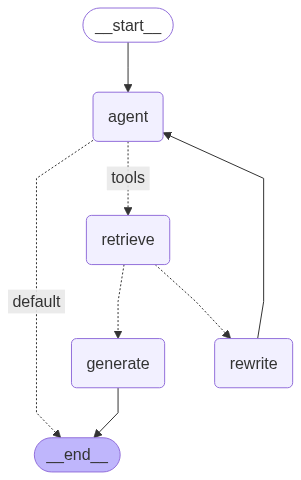

In [17]:
from IPython.display import Image, display

# Optional: visualize the compiled LangGraph as a Mermaid diagram in Jupyter
try:
    mermaid_image = graph.get_graph(xray=True).draw_mermaid_png()
    display(Image(mermaid_image))
except Exception as e:
    print("Mermaid rendering failed (optional dependency missing or graph misconfigured).")
    print(f"Error: {e}")
